In [3]:
#imports
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import cv2
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

In [25]:
# constants
DATA_PATH = './data'
TRAIN_VIDEO = './data/VIDEO/train.mp4'
print(TRAIN_VIDEO)
TEST_VIDEO = './data/VIDEO/test.mp4'
TRAIN_FRAMES_RAW = './data/IMG/train_raw/'
TEST_FRAMES_RAW = './data/IMG/test_raw/'
TRAIN_FRAMES_CROPPED = './data/IMG/train_cropped/'
TRAIN_FRAMES = './data/IMG/train/'
TEST_FRAMES = './data/IMG/test/'
OPT_ACC = './data/IMG/opt_acc/'
OPT_ACC_TEST = './data/IMG/opt_acc_test/'
train_frames = 20400
test_frames = 10798

./data/VIDEO/train.mp4


# Data Preparation

In [219]:
#grabbing frames and saving to folder
def save_frames(video, save_loc):
    vidcap = cv2.VideoCapture(video)
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite(save_loc + "frame%d.jpg" % count, image)     # save frame as JPEG file      
      success,image = vidcap.read()
      count += 1

In [213]:
save_frames(TRAIN_VIDEO, TRAIN_FRAMES_RAW)

In [220]:
save_frames(TEST_VIDEO, TEST_FRAMES_RAW)

# Augmentation Functions

In [7]:
def crop_image(path):
    img = cv2.imread(path)
    crop_img = img[25:375, :]
    crop_img = cv2.resize(crop_img, (220, 66), interpolation = cv2.INTER_AREA)
    img_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    return img_rgb

In [29]:
def adjust_brightness(img, bright_factor):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb
    

In [6]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    
    return rgb_flow

## Testing Optical Flow

In [ ]:
# test method for augmentation here
i = 0
while i < 5:
    img_1 = crop_image(TEST_FRAMES_RAW + f'frame{i}.jpg')
    img_2 = crop_image(TEST_FRAMES_RAW + f'frame{i+1}.jpg')
    opt_flow = opticalFlowDense(img_1,img_2)
    plt.figure(figsize = (10, 20))
    plt.imshow(img_1)
    plt.figure(figsize = (10, 20))
    plt.imshow(img_2)
    plt.figure(figsize = (10, 20))
    plt.imshow(opt_flow)
    i += 1
plt.show()

# Creating Test Set

In [15]:
def save_test(save_loc):
    for i in range(0,10797):
        frame_cur = crop_image(TEST_FRAMES_RAW + f'frame{i}.jpg')
        frame_next = crop_image(TEST_FRAMES_RAW + f'frame{i + 1}.jpg')
        opt_flow = opticalFlowDense(frame_cur,frame_next)
        cv2.imwrite(save_loc + f"frame{i}.jpg", opt_flow)
        
    

In [ ]:
save_test(TEST_FRAMES)

# Creating CSV for Testing Set

In [28]:
#make filenames
filenames = []
frame_id = []
for i in range(0,test_frames):
    filenames.append('opt_acc_test/' + f"frame{i}.jpg")
    frame_id.append(i)

df = pd.DataFrame({'filename':filenames, 'frame_id': frame_id})
df.drop(df.tail(1).index,inplace=True)
df.to_csv('test-acc.csv')

# Creating Train Set

In [ ]:
def save_train(save_loc):
    for i in range(0,10797):
        frame_cur = crop_image(TRAIN_FRAMES_RAW + f'frame{i}.jpg')
        frame_next = crop_image(TRAIN_FRAMES_RAW + f'frame{i + 1}.jpg')
        opt_flow = opticalFlowDense(frame_cur,frame_next)
        cv2.imwrite(save_loc + f"frame{i}.jpg", opt_flow)

In [ ]:
save_train(TRAIN_FRAMES)

# Creating CSV for Train Set

In [143]:
#make velocity column
velocity = np.loadtxt('./data/OUTPUT/train.txt')

#make filename and 
filenames = []
frame_id = []
for i in range(0,20400):
    filenames.append('train/' + f"frame{i}.jpg")
    frame_id.append(i)

#make valid set
np.random.seed(1000)
is_valid = []
for i in range(0,20400):
    randInt = np.random.randint(9)
    if (randInt >= 1):
        is_valid.append(False)
    else:
        is_valid.append(True)

In [201]:
df = pd.DataFrame({'filename':filenames, 'frame_id': frame_id, 'velocity': velocity, 'is_valid': is_valid})

In [202]:
df.drop(df.tail(1).index,inplace=True)

In [203]:
df

,filename,frame_id,velocity,is_valid
0,train/frame0.jpg,0,28.105569,False
1,train/frame1.jpg,1,28.105569,False
2,train/frame2.jpg,2,28.106527,False
3,train/frame3.jpg,3,28.130404,True
4,train/frame4.jpg,4,28.109243,False
...,...,...,...,...
20394,train/frame20394.jpg,20394,2.364811,False
20395,train/frame20395.jpg,20395,2.329180,False
20396,train/frame20396.jpg,20396,2.289795,False
20397,train/frame20397.jpg,20397,2.292917,False


In [206]:
df.to_csv('train.csv')

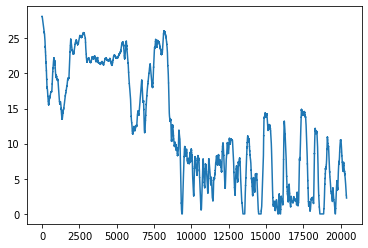

In [234]:
plt.plot(df['frame_id'], df['velocity'])

# Preparing Acceleration Dataset

I made this dataset where I concatenate optical acceleration to the bottom of the optical flow. I did this to combat my model's poor performance on rapid changes in speed. 

In [264]:
def save_train_acc(save_loc):
    for i in range(1,20399):
        frame_prev = crop_image(TRAIN_FRAMES_RAW + f'frame{i - 1}.jpg')
        frame_cur = crop_image(TRAIN_FRAMES_RAW + f'frame{i}.jpg')
        frame_next = crop_image(TRAIN_FRAMES_RAW + f'frame{i + 1}.jpg')
        opt_flow_1 = opticalFlowDense(frame_prev,frame_cur)
        opt_flow_2 = opticalFlowDense(frame_cur,frame_next)
        opt_acc = opticalFlowDense(opt_flow_1, opt_flow_2)
        out = np.concatenate((opt_flow_2, opt_acc), axis=0)
        cv2.imwrite(save_loc + f"frame{i}.jpg", out)

In [265]:
save_train_acc(OPT_ACC)

# Making CSV for Train Acceleration Set

In [268]:
#make velocity column
velocity = np.loadtxt('./output/train.txt')

#make filename and 
filenames = []
frame_id = []
for i in range(0,20400):
    filenames.append('train_acc/' + f"frame{i}.jpg")
    frame_id.append(i)

#make valid set
np.random.seed(1000)
is_valid = []
for i in range(0,20400):
    randInt = np.random.randint(9)
    if (randInt >= 1):
        is_valid.append(False)
    else:
        is_valid.append(True)

In [272]:
df = pd.DataFrame({'filename':filenames, 'frame_id': frame_id, 'velocity': velocity, 'is_valid': is_valid})
df.head()

,filename,frame_id,velocity,is_valid
0,train_acc/frame0.jpg,0,28.105569,False
1,train_acc/frame1.jpg,1,28.105569,False
2,train_acc/frame2.jpg,2,28.106527,False
3,train_acc/frame3.jpg,3,28.130404,True
4,train_acc/frame4.jpg,4,28.109243,False


In [273]:
df.drop(df.tail(1).index,inplace=True)
df.drop(df.head(1).index,inplace=True)

In [274]:
df

,filename,frame_id,velocity,is_valid
1,train_acc/frame1.jpg,1,28.105569,False
2,train_acc/frame2.jpg,2,28.106527,False
3,train_acc/frame3.jpg,3,28.130404,True
4,train_acc/frame4.jpg,4,28.109243,False
5,train_acc/frame5.jpg,5,28.088572,True
...,...,...,...,...
20394,train_acc/frame20394.jpg,20394,2.364811,False
20395,train_acc/frame20395.jpg,20395,2.329180,False
20396,train_acc/frame20396.jpg,20396,2.289795,False
20397,train_acc/frame20397.jpg,20397,2.292917,False


In [275]:
df.to_csv('train_acc.csv')

# Preparing Test Acceleration Set 

In [26]:
def save_augmented_acc(save_loc):
    for i in range(1,test_frames - 1):
        frame_prev = crop_image(TEST_FRAMES_RAW + f'frame{i - 1}.jpg')
        frame_cur = crop_image(TEST_FRAMES_RAW + f'frame{i}.jpg')
        frame_next = crop_image(TEST_FRAMES_RAW + f'frame{i + 1}.jpg')
        opt_flow_1 = opticalFlowDense(frame_prev,frame_cur)
        opt_flow_2 = opticalFlowDense(frame_cur,frame_next)
        opt_acc = opticalFlowDense(opt_flow_1, opt_flow_2)
        out = np.concatenate((opt_flow_2, opt_acc), axis=0)
        cv2.imwrite(save_loc + f"frame{i}.jpg", out)

In [27]:
save_augmented_acc(OPT_ACC_TEST)